# Pruning 101

In [1]:
# pip install torchprofile 1>/dev/null

In [2]:
import copy
import random

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

import torch.nn.functional as F

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [4]:
!nvidia-smi

Tue Jun 27 00:24:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.68.02    Driver Version: 510.68.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:17:00.0 Off |                  N/A |
| 55%   69C    P2   224W / 350W |   8238MiB / 24576MiB |     34%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    scheduler: StepLR,
    callbacks = None
) -> None:
    model.train()

    for inputs, targets in tqdm(dataloader, desc='train', leave=False):
        inputs = inputs.cuda()
        targets = targets.cuda()
        optimizer.zero_grad()

        # Forward inference
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        # Update optimizer
        optimizer.step()
        if callbacks is not None:
            for callback in callbacks:
                callback()
    
    scheduler.step()

In [6]:
@torch.inference_mode()
def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
    verbose=True,
) -> float:
    model.eval()

    num_samples = 0
    num_correct = 0

    for inputs, targets in tqdm(dataloader, desc="eval", leave=False):
        inputs = inputs.cuda()
        targets = targets.cuda()

        outputs = model(inputs)
        outputs = outputs.argmax(dim=1)

        # Update metrics
        num_samples += targets.size(0)
        num_correct += (outputs == targets).sum()

    return (num_correct / num_samples * 100).item()

## Helper Functions (Flops, Model Size calculation, etc.)

In [7]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=True):
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True, 
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True, 
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()
    
def get_model_weights(model):
    weights = [module.weight.cpu().detach() for module in model.modules() if isinstance(module, nn.Conv2d)]
    weights = [np.array(item) for sublist in weights for item in sublist.reshape(-1, 1)]
    weights = np.array(weights)
    return weights

def plot_model_weights(model, count_nonzero_only=True):
    weights = get_model_weights(model)
    weights = weights[weights != 0]
    plt.hist(weights, bins=500)
    plt.title("Weight Distribution")
    plt.ylabel("Count")
    plt.xlabel("Value")
    plt.xlim([-0.5, 0.5])
    plt.show()


def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

Define pruning functions.

In [8]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    num_zeros = round(num_elements * sparsity)
    importance = tensor.abs()
    threshold = importance.view(-1).kthvalue(num_zeros).values
    mask = torch.gt(importance, threshold)
    tensor.mul_(mask)

    return mask

In [9]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                if isinstance(sparsity_dict, dict):
                    masks[name] = fine_grained_prune(param, sparsity_dict[name])
                else:
                    assert(sparsity_dict < 1 and sparsity_dict >= 0)
                    if sparsity_dict > 0:
                        masks[name] = fine_grained_prune(param, sparsity_dict)
        return masks

Load the MNIST dataset.

In [10]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
to_image = lambda t: (t*0.3081+0.1307).squeeze(0).to('cpu').numpy()

dataset = {}
for split in ["train", "test"]:
    dataset[split] = MNIST(
        "data",
        train=(split == "train"),
        download=(split == "train"),
        transform=transform,
    )

dataloader = {}
for split in ['train', 'test']:
    dataloader[split] = DataLoader(
        dataset[split],
        batch_size=256 if split == 'train' else 1000,
        shuffle=(split == 'train'),
        num_workers=0,
        pin_memory=True
    )

Create a set of test images for demo.

In [11]:
demos = {0: 3, 1: 2, 2: 1, 3: 30, 4: 4, 5: 15, 6: 11, 7: 0, 8: 61, 9: 9}
demo_inputs, demo_images = [], []
for digit, index in demos.items():
    demo_inputs.append(copy.deepcopy(dataset['test'][index][0]))
    demo_images.append(to_image(demo_inputs[-1]))
demo_inputs = torch.stack(demo_inputs).cuda()

# Neural Network Model

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) # 1 x 32 x 3 x 3 = 288 parameters
        self.conv2 = nn.Conv2d(32, 64, 3, 1) # 32 x 64 x 3 x 3=18,432 paramters
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128) # 9216 x 128 = 1,179,648 parameters
        self.fc2 = nn.Linear(128, 10) # 128 x 10 = 1,280 parameters

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Net().cuda()

# Let's Visualize the Demo Images

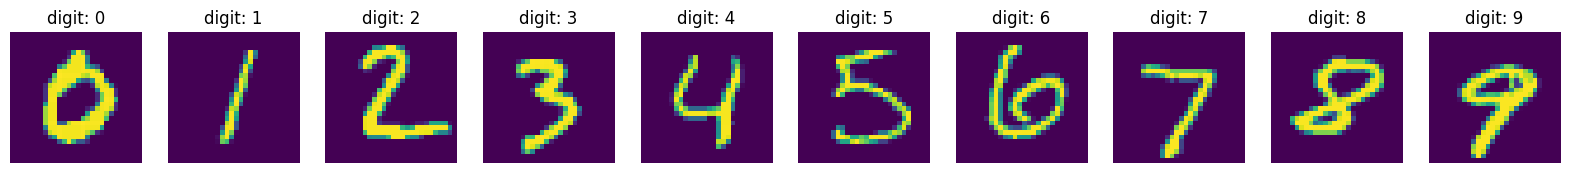

In [13]:
def visualize(with_predictions=False):
    plt.figure(figsize=(20, 10))
    predictions = model(demo_inputs).argmax(dim=1) if with_predictions else None
    for digit, index in demos.items():
        plt.subplot(1, 10, digit + 1)
        plt.imshow(demo_images[digit])
        if predictions is None:
            plt.title(f"digit: {digit}")
        else:
            plt.title(f"digit: {digit}\npred: {int(predictions[digit])}")
        plt.axis('off')
    plt.show()

visualize()

# Pre-train Neural Network on MNIST

In [14]:
lr = 1.0
lr_step_gamma = 0.7
num_epochs = 5

optimizer = Adadelta(model.parameters(), lr=lr)
criterion = F.nll_loss
scheduler = StepLR(optimizer, step_size=1, gamma=lr_step_gamma)

best_accuracy = 0
best_checkpoint = dict()
for epoch in range(num_epochs):
    train(model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1:>2d} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

print(f"=> loading best checkpoint")
model.load_state_dict(best_checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(best_checkpoint['state_dict'])

train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  1 Accuracy 97.35% / Best Accuracy: 97.35%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  2 Accuracy 98.60% / Best Accuracy: 98.60%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  3 Accuracy 98.91% / Best Accuracy: 98.91%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  4 Accuracy 98.88% / Best Accuracy: 98.91%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  5 Accuracy 98.98% / Best Accuracy: 98.98%
=> loading best checkpoint


# Let's First Evaluate the Accuracy and Model Size of Dense Model

Let's first evaluate the accuracy and model size of this model.

eval:   0%|          | 0/10 [00:00<?, ?it/s]

dense model has accuracy=98.98%
dense model has size=4.58 MiB


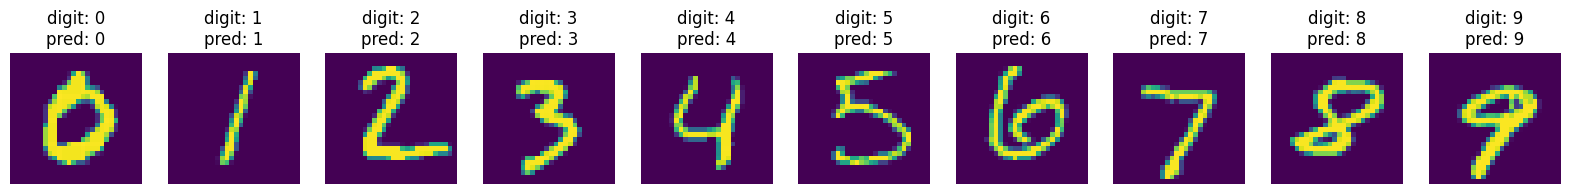

In [15]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")
visualize(True)

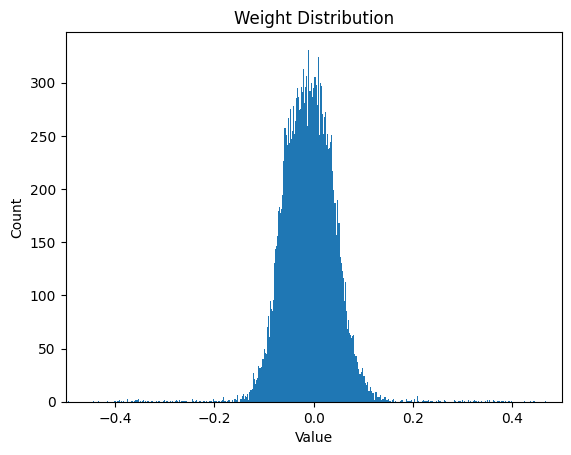

In [16]:
plot_model_weights(model)

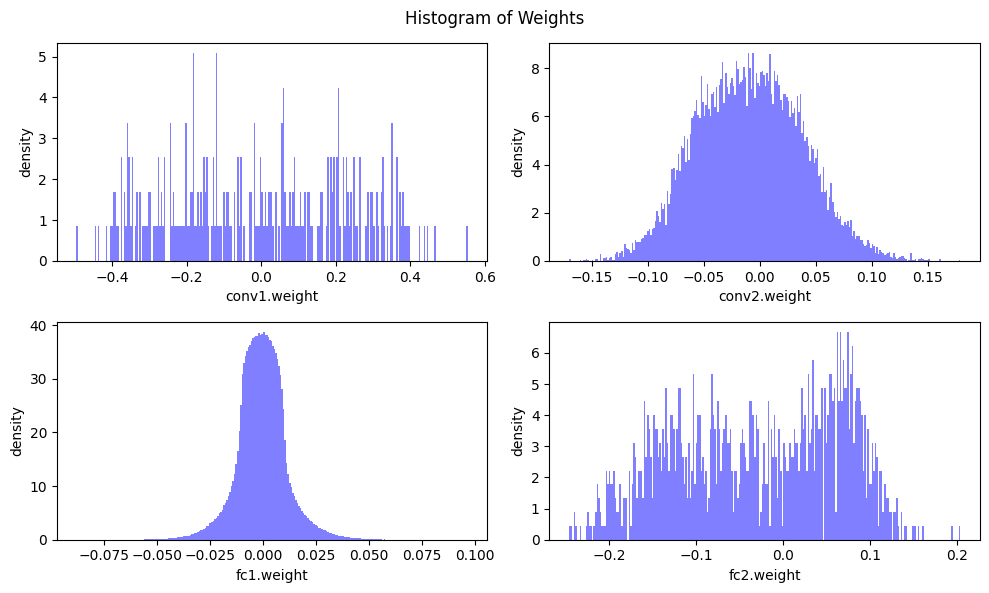

In [17]:
plot_weight_distribution(model)

# Let's Prune the Model and Re-Evaluate the Accuracy.

eval:   0%|          | 0/10 [00:00<?, ?it/s]

20.0% sparse model has accuracy=98.98%
20.0% sparse model has size=3.66 MiB, which is 1.25X smaller than the 4.58 MiB dense model


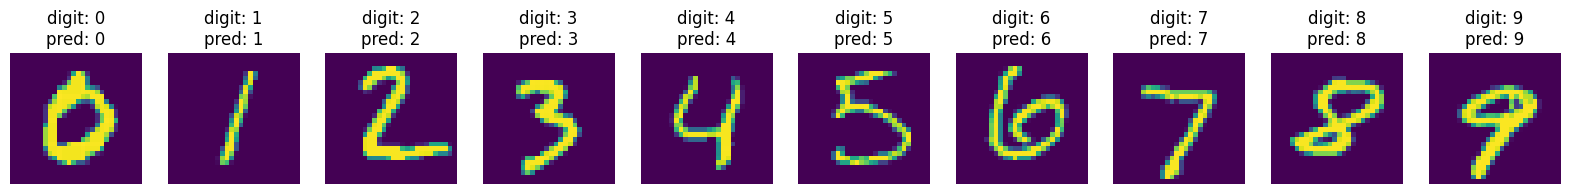

In [19]:
sparsity = 20 / 100
recover_model()
pruner = FineGrainedPruner(model, sparsity)
pruner.apply(model)
sparse_model_accuracy = evaluate(model, dataloader['test'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"{sparsity*100}% sparse model has accuracy={sparse_model_accuracy:.2f}%")
print(f"{sparsity*100}% sparse model has size={sparse_model_size/MiB:.2f} MiB, "
      f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
      f"the {dense_model_size/MiB:.2f} MiB dense model")
visualize(True)

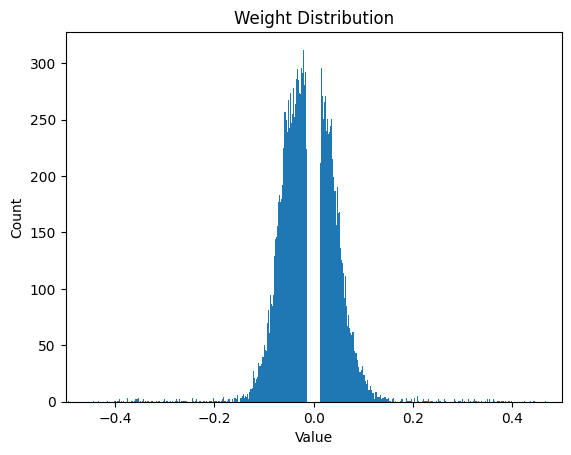

In [20]:
plot_model_weights(model)

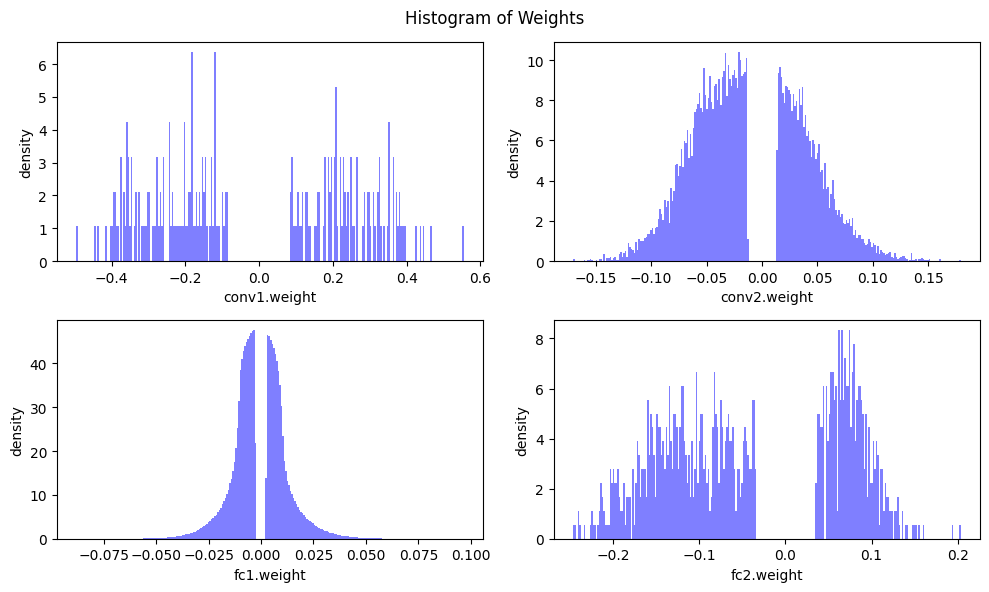

In [21]:
plot_weight_distribution(model, count_nonzero_only=True)

### Let's prune more aggressively!

eval:   0%|          | 0/10 [00:00<?, ?it/s]

80.0% sparse model has accuracy=59.81%
80.0% sparse model has size=0.92 MiB, which is 5.00X smaller than the 4.58 MiB dense model


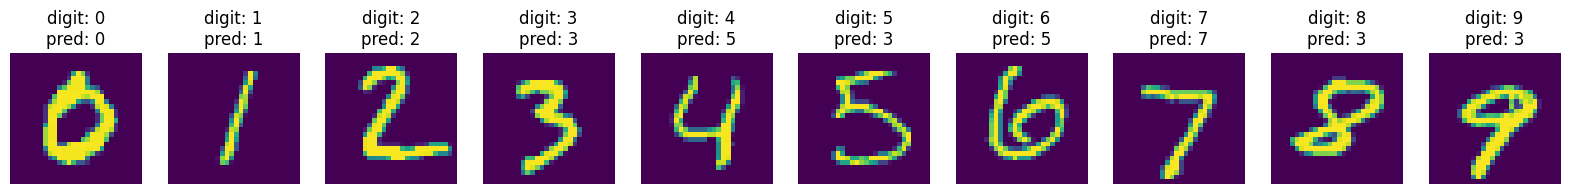

In [23]:
sparsity = 80 / 100
recover_model()
pruner = FineGrainedPruner(model, sparsity)
pruner.apply(model)
sparse_model_accuracy = evaluate(model, dataloader['test'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"{sparsity*100}% sparse model has accuracy={sparse_model_accuracy:.2f}%")
print(f"{sparsity*100}% sparse model has size={sparse_model_size/MiB:.2f} MiB, "
      f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
      f"the {dense_model_size/MiB:.2f} MiB dense model")
visualize(True)

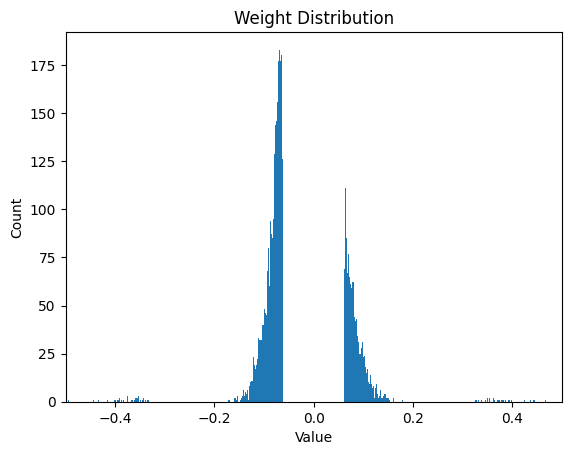

In [24]:
plot_model_weights(model)

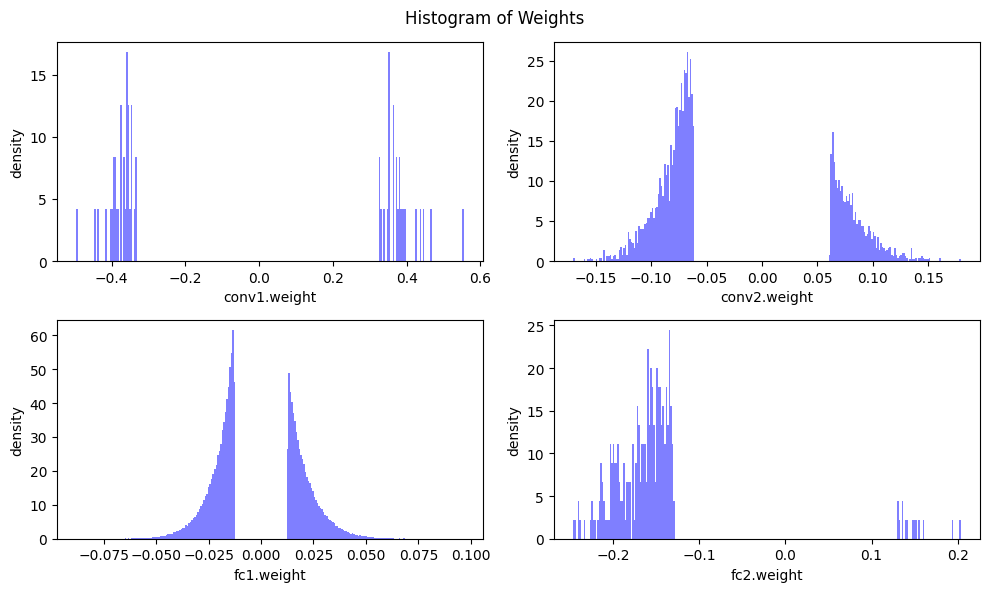

In [25]:
plot_weight_distribution(model, count_nonzero_only=True)

### Let's try even more aggressively!

eval:   0%|          | 0/10 [00:00<?, ?it/s]

90.0% sparse model has accuracy=18.65%
90.0% sparse model has size=0.46 MiB, which is 9.98X smaller than the 4.58 MiB dense model


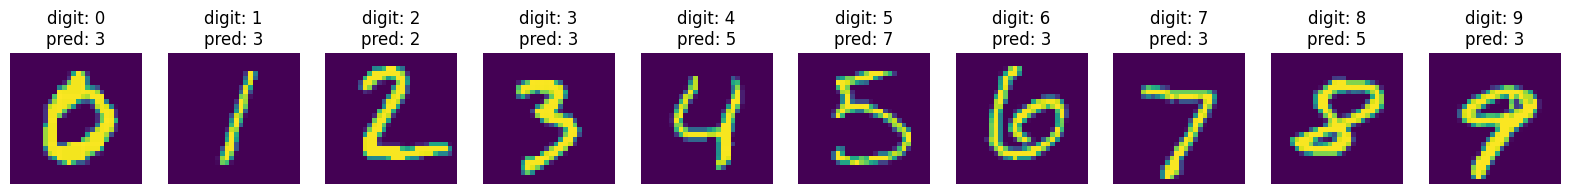

In [27]:
sparsity = 90 / 100
recover_model()
pruner = FineGrainedPruner(model, sparsity)
pruner.apply(model)
sparse_model_accuracy = evaluate(model, dataloader['test'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"{sparsity*100}% sparse model has accuracy={sparse_model_accuracy:.2f}%")
print(f"{sparsity*100}% sparse model has size={sparse_model_size/MiB:.2f} MiB, "
      f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
      f"the {dense_model_size/MiB:.2f} MiB dense model")
visualize(True)

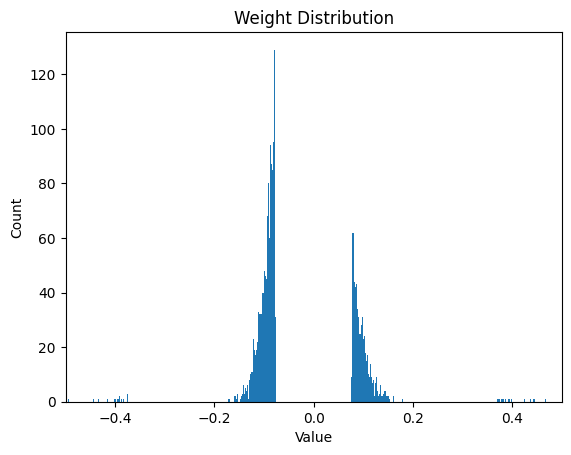

In [28]:
plot_model_weights(model)

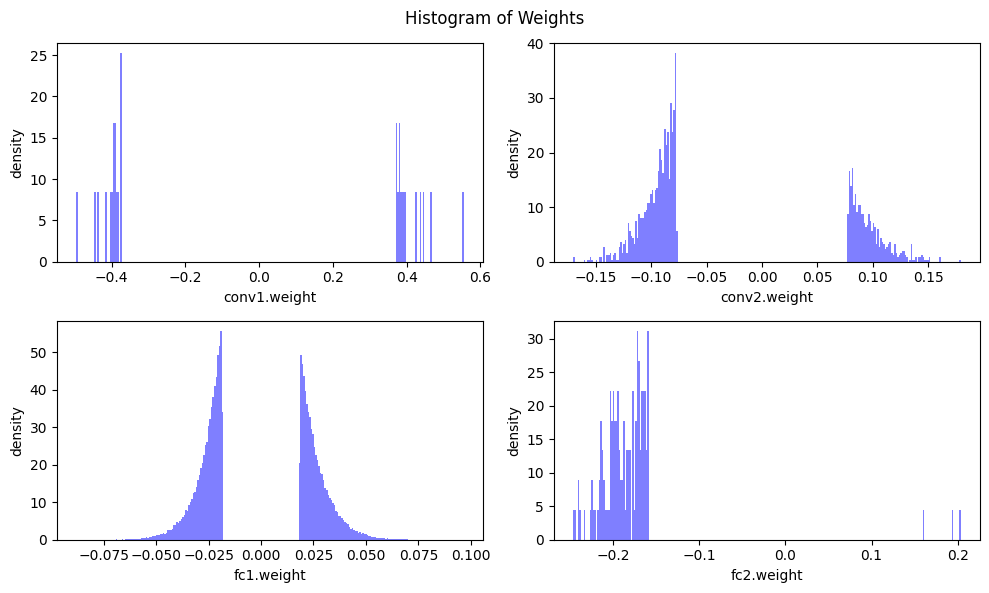

In [29]:
plot_weight_distribution(model, count_nonzero_only=True)

### More?!

eval:   0%|          | 0/10 [00:00<?, ?it/s]

95.0% sparse model has accuracy=9.31%
95.0% sparse model has size=0.23 MiB, which is 19.93X smaller than the 4.58 MiB dense model


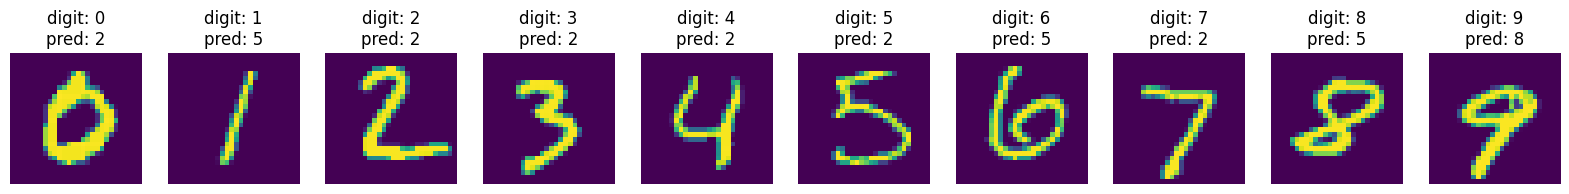

In [31]:
sparsity = 95 / 100
recover_model()
pruner = FineGrainedPruner(model, sparsity)
pruner.apply(model)
sparse_model_accuracy = evaluate(model, dataloader['test'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"{sparsity*100}% sparse model has accuracy={sparse_model_accuracy:.2f}%")
print(f"{sparsity*100}% sparse model has size={sparse_model_size/MiB:.2f} MiB, "
      f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
      f"the {dense_model_size/MiB:.2f} MiB dense model")
visualize(True)

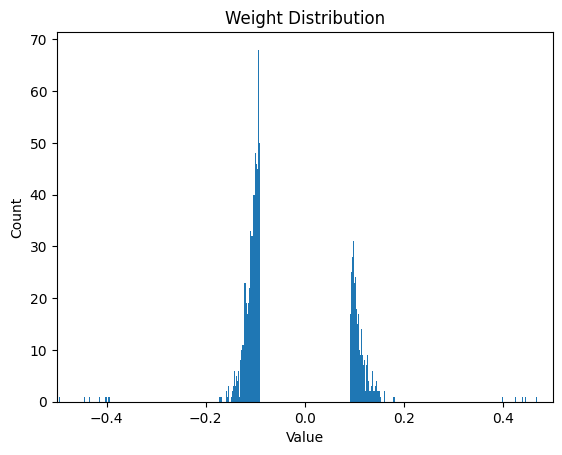

In [32]:
plot_model_weights(model)

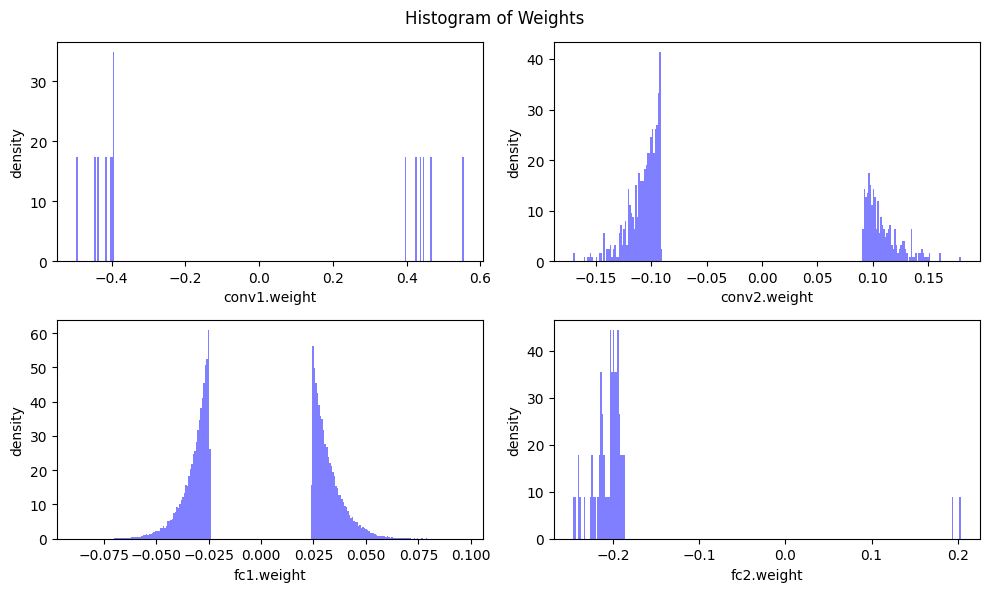

In [33]:
plot_weight_distribution(model, count_nonzero_only=True)

### Should we make it higher?!

eval:   0%|          | 0/10 [00:00<?, ?it/s]

99.0% sparse model has accuracy=10.32%
99.0% sparse model has size=0.05 MiB, which is 98.11X smaller than the 4.58 MiB dense model


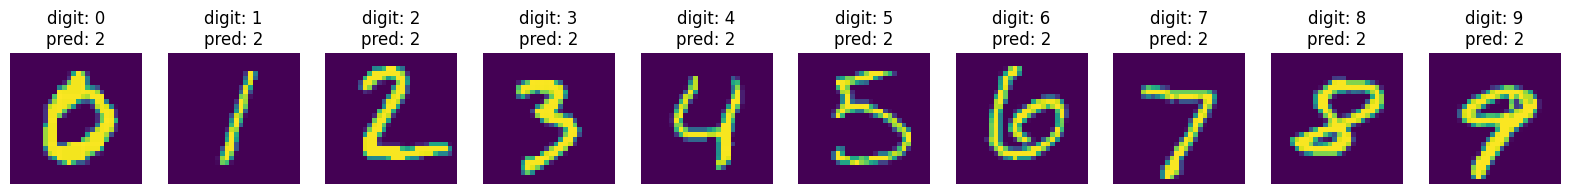

In [35]:
sparsity = 99 / 100
recover_model()
pruner = FineGrainedPruner(model, sparsity)
pruner.apply(model)
sparse_model_accuracy = evaluate(model, dataloader['test'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"{sparsity*100}% sparse model has accuracy={sparse_model_accuracy:.2f}%")
print(f"{sparsity*100}% sparse model has size={sparse_model_size/MiB:.2f} MiB, "
      f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
      f"the {dense_model_size/MiB:.2f} MiB dense model")
visualize(True)

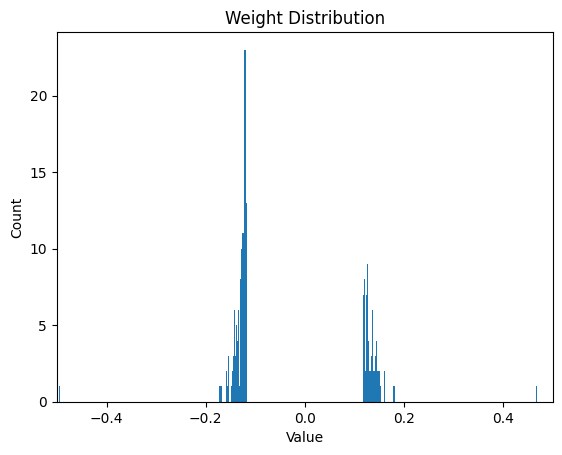

In [36]:
plot_model_weights(model)

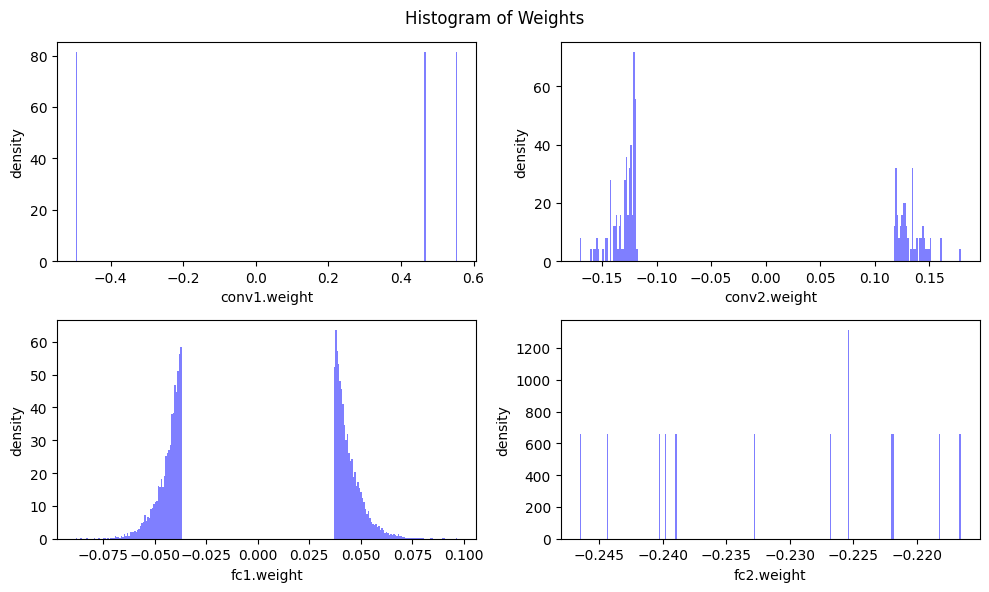

In [37]:
plot_weight_distribution(model, count_nonzero_only=True)

# Let's Fine-tune the Pruned Model to Get Higher Accuracy

In [39]:
sparsity = 90 / 100
recover_model()
pruner = FineGrainedPruner(model, sparsity)
pruner.apply(model)
sparse_model_accuracy = evaluate(model, dataloader['test'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)

eval:   0%|          | 0/10 [00:00<?, ?it/s]

In [40]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)

best_sparse_checkpoint = dict()
best_sparse_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_sparse_accuracy
    if is_best:
        best_sparse_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_sparse_accuracy = accuracy
    print(f'    Epoch {epoch+1} Sparse Accuracy {accuracy:.2f}% / Best Sparse Accuracy: {best_sparse_accuracy:.2f}%')


Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 1 Sparse Accuracy 98.10% / Best Sparse Accuracy: 98.10%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 2 Sparse Accuracy 98.34% / Best Sparse Accuracy: 98.34%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 3 Sparse Accuracy 98.59% / Best Sparse Accuracy: 98.59%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 4 Sparse Accuracy 98.69% / Best Sparse Accuracy: 98.69%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 5 Sparse Accuracy 98.68% / Best Sparse Accuracy: 98.69%


eval:   0%|          | 0/10 [00:00<?, ?it/s]

90.0% sparse model has accuracy=98.69%
90.0% sparse model has size=0.46 MiB, which is 9.98X smaller than the 4.58 MiB dense model


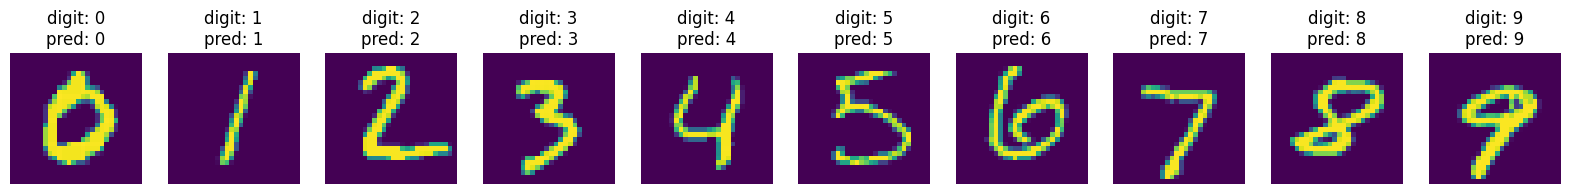

In [41]:
model.load_state_dict(best_sparse_checkpoint['state_dict'])
sparse_model_accuracy = evaluate(model, dataloader['test'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"{sparsity*100}% sparse model has accuracy={sparse_model_accuracy:.2f}%")
print(f"{sparsity*100}% sparse model has size={sparse_model_size/MiB:.2f} MiB, "
      f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
      f"the {dense_model_size/MiB:.2f} MiB dense model")
visualize(True)

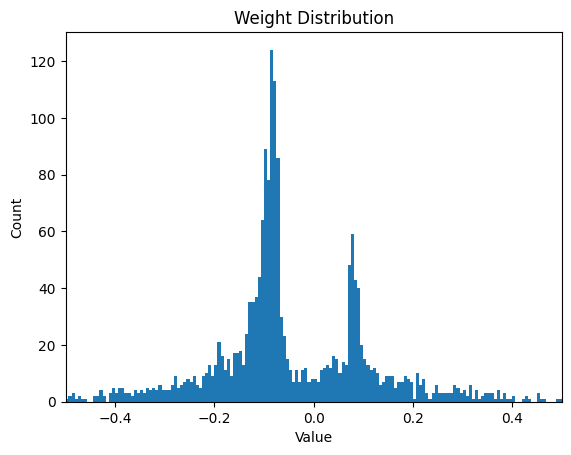

In [42]:
plot_model_weights(model)

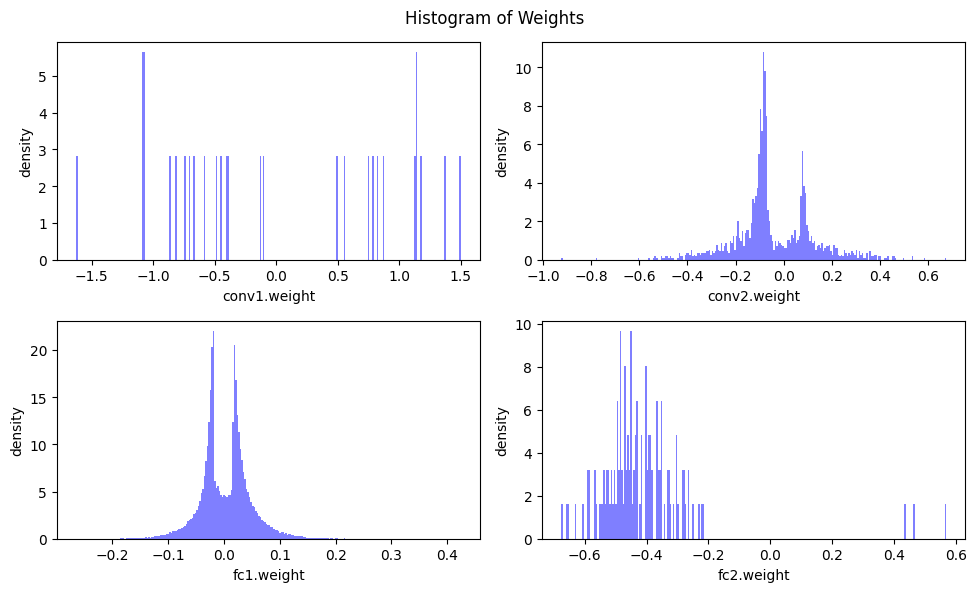

In [43]:
plot_weight_distribution(model)

### Sparser model

In [45]:
sparsity = 95 / 100
recover_model()
pruner = FineGrainedPruner(model, sparsity)
pruner.apply(model)
sparse_model_accuracy = evaluate(model, dataloader['test'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)

eval:   0%|          | 0/10 [00:00<?, ?it/s]

In [46]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)

best_sparse_checkpoint = dict()
best_sparse_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_sparse_accuracy
    if is_best:
        best_sparse_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_sparse_accuracy = accuracy
    print(f'    Epoch {epoch+1} Sparse Accuracy {accuracy:.2f}% / Best Sparse Accuracy: {best_sparse_accuracy:.2f}%')


Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 1 Sparse Accuracy 94.36% / Best Sparse Accuracy: 94.36%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 2 Sparse Accuracy 95.81% / Best Sparse Accuracy: 95.81%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 3 Sparse Accuracy 96.69% / Best Sparse Accuracy: 96.69%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 4 Sparse Accuracy 96.90% / Best Sparse Accuracy: 96.90%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 5 Sparse Accuracy 97.15% / Best Sparse Accuracy: 97.15%


eval:   0%|          | 0/10 [00:00<?, ?it/s]

95.0% sparse model has accuracy=97.15%
95.0% sparse model has size=0.23 MiB, which is 19.93X smaller than the 4.58 MiB dense model


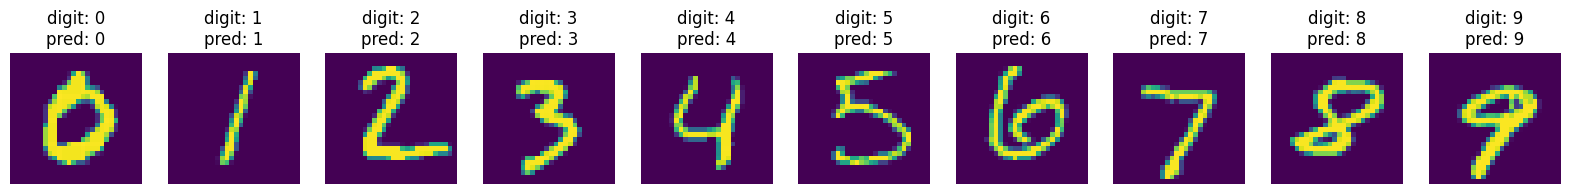

In [47]:
model.load_state_dict(best_sparse_checkpoint['state_dict'])
sparse_model_accuracy = evaluate(model, dataloader['test'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"{sparsity*100}% sparse model has accuracy={sparse_model_accuracy:.2f}%")
print(f"{sparsity*100}% sparse model has size={sparse_model_size/MiB:.2f} MiB, "
      f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
      f"the {dense_model_size/MiB:.2f} MiB dense model")
visualize(True)

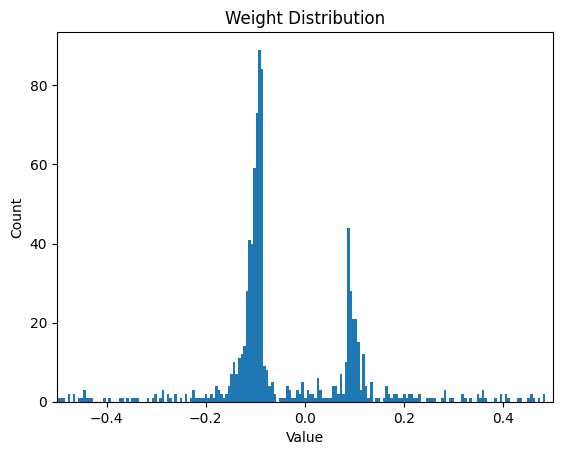

In [48]:
plot_model_weights(model)

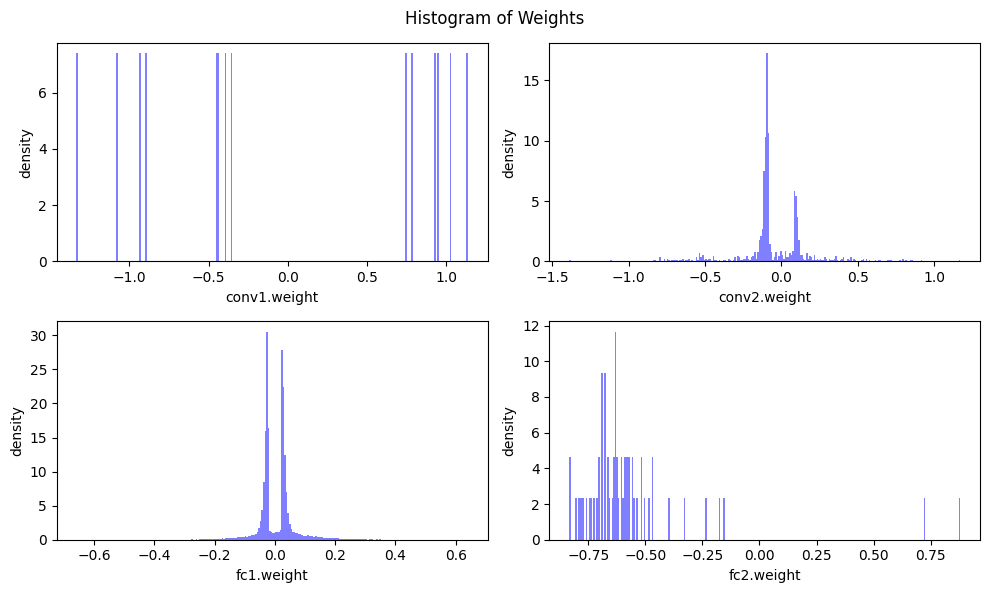

In [49]:
plot_weight_distribution(model)

### Even sparser?!

In [51]:
sparsity = 97 / 100
recover_model()
pruner = FineGrainedPruner(model, sparsity)
pruner.apply(model)
sparse_model_accuracy = evaluate(model, dataloader['test'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)

eval:   0%|          | 0/10 [00:00<?, ?it/s]

In [52]:
num_finetune_epochs = 10
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs//2)

best_sparse_checkpoint = dict()
best_sparse_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_sparse_accuracy
    if is_best:
        best_sparse_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_sparse_accuracy = accuracy
    print(f'    Epoch {epoch+1} Sparse Accuracy {accuracy:.2f}% / Best Sparse Accuracy: {best_sparse_accuracy:.2f}%')


Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 1 Sparse Accuracy 87.85% / Best Sparse Accuracy: 87.85%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 2 Sparse Accuracy 89.40% / Best Sparse Accuracy: 89.40%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 3 Sparse Accuracy 91.17% / Best Sparse Accuracy: 91.17%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 4 Sparse Accuracy 92.14% / Best Sparse Accuracy: 92.14%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 5 Sparse Accuracy 92.27% / Best Sparse Accuracy: 92.27%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 6 Sparse Accuracy 92.27% / Best Sparse Accuracy: 92.27%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 7 Sparse Accuracy 92.47% / Best Sparse Accuracy: 92.47%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 8 Sparse Accuracy 92.30% / Best Sparse Accuracy: 92.47%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 9 Sparse Accuracy 92.40% / Best Sparse Accuracy: 92.47%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 10 Sparse Accuracy 90.30% / Best Sparse Accuracy: 92.47%


eval:   0%|          | 0/10 [00:00<?, ?it/s]

97.0% sparse model has accuracy=92.47%
97.0% sparse model has size=0.14 MiB, which is 33.12X smaller than the 4.58 MiB dense model


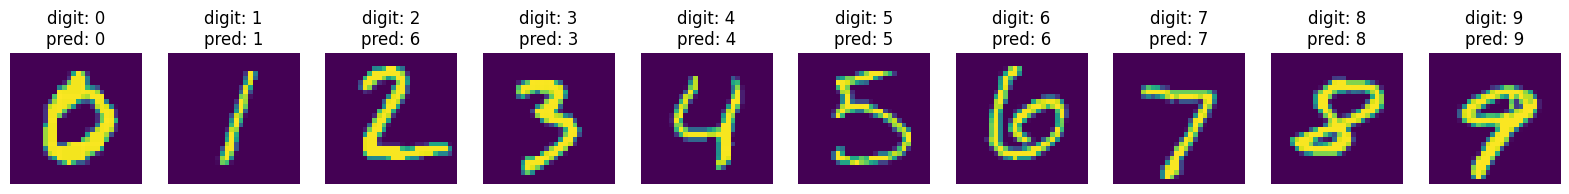

In [53]:
model.load_state_dict(best_sparse_checkpoint['state_dict'])
sparse_model_accuracy = evaluate(model, dataloader['test'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"{sparsity*100}% sparse model has accuracy={sparse_model_accuracy:.2f}%")
print(f"{sparsity*100}% sparse model has size={sparse_model_size/MiB:.2f} MiB, "
      f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
      f"the {dense_model_size/MiB:.2f} MiB dense model")
visualize(True)

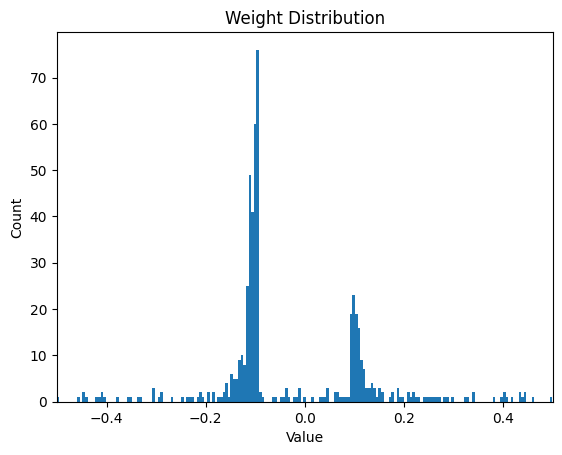

In [54]:
plot_model_weights(model)

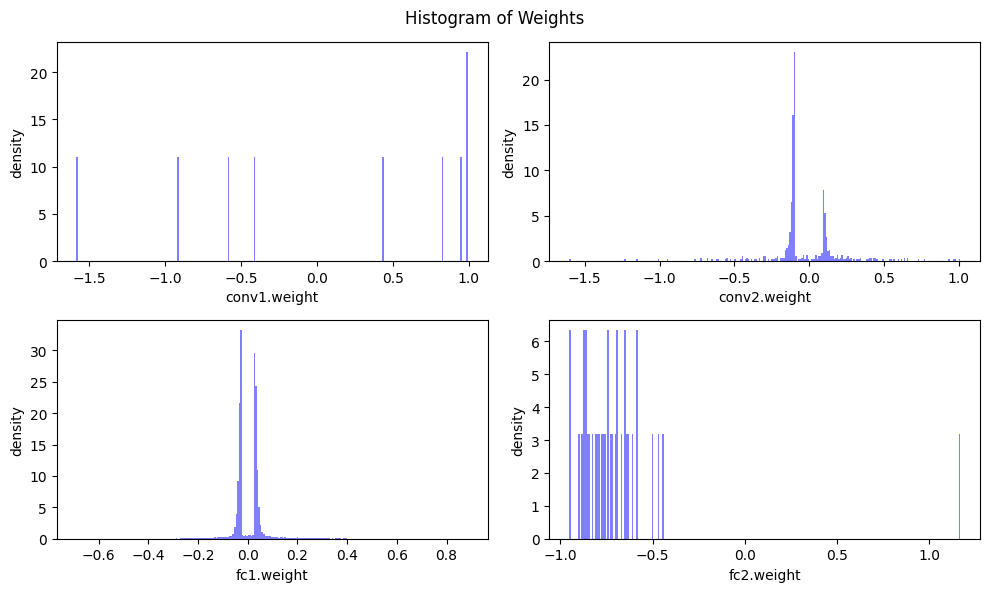

In [55]:
plot_weight_distribution(model)

## Note

The results that we have achieved here are for a very simple network on MNIST.